In [1]:
import pandas as pd
import jieba
from collections import Counter

import pandas as pd
import jieba
from collections import Counter
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# 读取停用词
stop_word_path ='data/stopwords.txt' 
with open(stop_word_path,'r') as f:
   stopwords = set(line.strip() for line in f)

def process_text(text):
    return [word for word in jieba.lcut(text) if word not in stopwords]

def data_load(file_path,num_workers=4):
    # 使用 pandas 读取 CSV 文件
    df = pd.read_csv(file_path)
    labels = df['label'].values
    
    # 并行处理分词
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        text_list = list(tqdm(executor.map(process_text, df['review']), total=len(df), desc="Tokenizing"))
    
    # 统计词频
    word_counts = Counter(word for text in text_list for word in text)
    
    # 构建词汇表
    word_to_idx = {word: idx + 1 for idx, word in enumerate(word_counts.keys())}
    
    # 将文本转换为 ID 序列
    text_ids = [[word_to_idx.get(word, 0) for word in text] for text in text_list]
    
    return text_ids, labels, len(word_counts.keys())+1
    
text_ids, labels,word_len = data_load('data/weibo_senti_100k.csv')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model cost 0.945 seconds.
Prefix dict has been built successfully.
Loading model cost 0.945 seconds.
Prefix dict has been built successfully.
Loading model cost 0.962 seconds.
Prefix dict has been built successfully.
Loading model cost 0.966 seconds.
Prefix dict has been built successfully.
Tokenizing: 100%|██████████| 119988/119988 [00:17<00:00, 6773.89it/s]


Text length statistics:
Min: 0
Max: 123
Mean: 19.42
Median: 15.0
95th Percentile: 47.00
99th Percentile: 57.00
Chosen max_seq_len: 47


/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38271

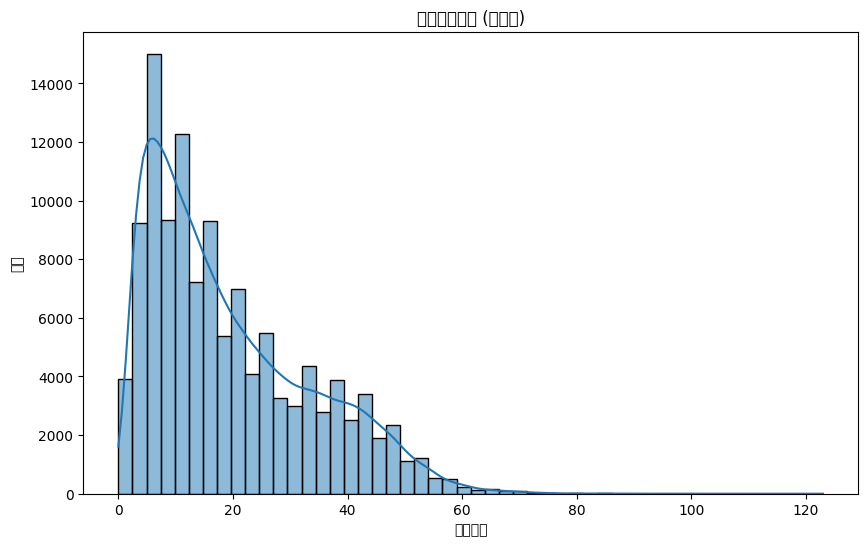

/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/miniconda/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998

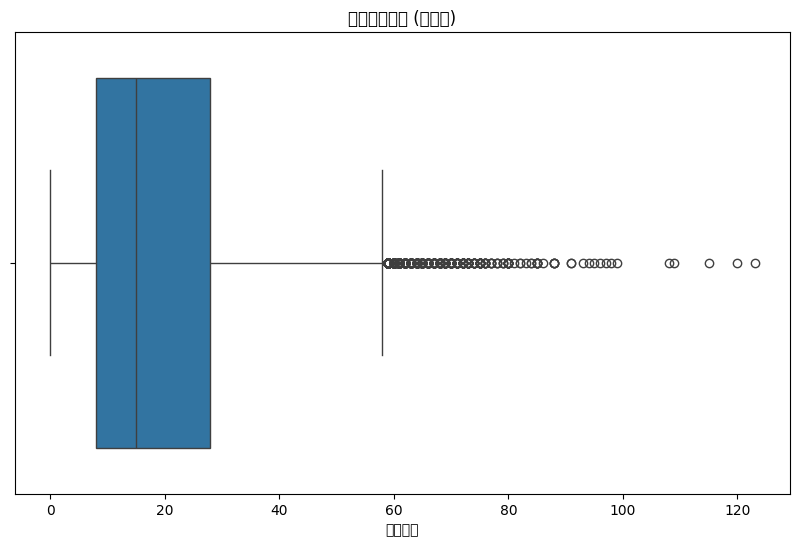

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

text_lengths = [len(e) for e in text_ids]

# 打印描述性统计信息
print("Text length statistics:")
print(f"Min: {min(text_lengths)}")
print(f"Max: {max(text_lengths)}")
print(f"Mean: {np.mean(text_lengths):.2f}")
print(f"Median: {np.median(text_lengths)}")
print(f"95th Percentile: {np.percentile(text_lengths, 95):.2f}")
print(f"99th Percentile: {np.percentile(text_lengths, 99):.2f}")

# 选择最大序列长度，例如第95百分位
max_seq_len = int(np.percentile(text_lengths, 95))
print(f"Chosen max_seq_len: {max_seq_len}")
# 可视化文本长度分布
plt.figure(figsize=(10, 6))

# 直方图
sns.histplot(text_lengths, bins=50, kde=True)
plt.title('文本长度分布 (直方图)')
plt.xlabel('文本长度')
plt.ylabel('频率')
plt.show()

# 箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x=text_lengths)
plt.title('文本长度分布 (箱线图)')
plt.xlabel('文本长度')
plt.show()



In [3]:


from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import math

from torch.utils.data import Dataset, DataLoader
import random
import torch


class WeiboDataset(Dataset):
    def __init__(self, data, label, max_seq_len):
        super(WeiboDataset,self).__init__()
        self.data = data
        self.label = label
        self.max_seq_len = max_seq_len
    def __getitem__(self, idx):
        padding_len = self.max_seq_len - len(self.data[idx])
        if padding_len > 0:
            x = self.data[idx]+[0]*padding_len
        else:
            pos = random.randint(0,-padding_len)
            x = self.data[idx][pos:pos+self.max_seq_len]
        return torch.tensor(x), torch.tensor(self.label[idx])
    def __len__(self):
        return len(self.label)

class SingleHeadAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SingleHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        
        # 线性变换层
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        
        # 线性变换
        Q = self.query(x)  # [batch_size, seq_len, embed_dim]
        K = self.key(x)    # [batch_size, seq_len, embed_dim]
        V = self.value(x)  # [batch_size, seq_len, embed_dim]
        
        # 缩放点积注意力
        energy = torch.bmm(Q, K.transpose(1, 2)) / math.sqrt(embed_dim)  # [batch_size, seq_len, seq_len]
        
        # 应用 Softmax 归一化
        attention_weights = torch.softmax(energy, dim=-1)  # [batch_size, seq_len, seq_len]
        
        # 加权求和
        attended_values = torch.bmm(attention_weights, V)  # [batch_size, seq_len, embed_dim]
        
        # 求平均或取特定位置（例如第一个token），这里我们采用全局平均池化
        output = attended_values.mean(dim=1)  # [batch_size, embed_dim]
        
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape = [seq_len, batch_size, embedding_dim]
        x = x + self.pe[:x.size(0), :]
        return x

class ConvBlock(nn.Module):
    def __init__(self, emb_dim):
        super(ConvBlock, self).__init__()
        
        # 定义卷积层和其他组件
        self.conv1 = nn.Conv1d(emb_dim, emb_dim * 4, kernel_size=1)
        self.depthwise_conv = nn.Conv1d(emb_dim * 4, emb_dim * 4, kernel_size=3, groups=emb_dim * 4, padding=1)
        self.layer_norm1 = nn.LayerNorm(emb_dim * 4)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout1d(0.3)
        self.conv3 = nn.Conv1d(emb_dim * 4, emb_dim, kernel_size=1)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x.transpose(-1, -2))  # 转置以适应LayerNorm
        out = self.depthwise_conv(out)
        out = self.layer_norm1(out.transpose(-1, -2)).transpose(-1,-2)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.conv3(out)
        out = self.layer_norm2(out.transpose(-1, -2))  # 同上
        out = self.relu2(out+residual)

        return out

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim,max_seq_len, num_classes, depth=4):
        super(TextClassifier, self).__init__()
        self.pos_encoder = PositionalEncoding(emb_dim,max_seq_len)
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.stem_conv = nn.Conv1d(emb_dim, emb_dim, kernel_size=4, stride=4,padding=3)
        self.stem_norm = nn.LayerNorm(emb_dim)
        self.max_pool = nn.MaxPool1d(kernel_size=2,stride=2)
        self.gelu = nn.GELU()
        self.stage = nn.ModuleList([ConvBlock(emb_dim) for i in range(depth)])
        self.attention = SingleHeadAttention(emb_dim)
        self.fc = nn.Linear(emb_dim,num_classes)

    def forward(self, x):
        x = self.emb(x)
        x = self.pos_encoder(x.transpose(1,0)).transpose(1,0)
        x = self.stem_conv(x.transpose(-1,-2)).transpose(-1,-2)
        x = self.stem_norm(x)
        x = self.max_pool(x.transpose(-1,-2)).transpose(-1,-2)
        x = self.gelu(x)
        for stage in self.stage:
            x = stage(x)
        x = self.attention(x)
        x = self.fc(x)
        return x


vocab_size = word_len
emb_dim = 256
max_seq_len = 57
num_classes = 2
batch_size = 64
epochs = 10

X_train,X_test, y_train,y_test = train_test_split(text_ids, labels,test_size=0.2,shuffle=True)
train_ds = WeiboDataset(X_train, y_train, max_seq_len)
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_cnn = TextClassifier(vocab_size, emb_dim,max_seq_len,num_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_cnn.parameters(),lr=0.001)
iteration = 0
mean_loss = []
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch[0].to(device)
        y_true = batch[1].to(device)

        y_pred = text_cnn(inputs)
        loss = loss_func(y_pred, y_true)
        loss.backward()
        optimizer.step()
        iteration += 1
        mean_loss.append(loss.item())
        if iteration % 40 == 0:
            print(f"iteration = {iteration}, loss = {sum(mean_loss)/len(mean_loss)}")
            mean_loss = []
    print(f"######## epoch = {epoch + 1} ###########")
    #torch.save(text_cnn.state_dict(),f'trained_models/model_{epoch+1}.pth')


iteration = 40, loss = 0.9834000989794731
iteration = 80, loss = 0.7305996164679527
iteration = 120, loss = 0.6978797599673271
iteration = 160, loss = 0.6990311607718468
iteration = 200, loss = 0.6975589409470558
iteration = 240, loss = 0.7007101088762283
iteration = 280, loss = 0.6928309485316276
iteration = 320, loss = 0.6895558670163154
iteration = 360, loss = 0.541324720531702
iteration = 400, loss = 0.3926148660480976
iteration = 440, loss = 0.2808707483112812
iteration = 480, loss = 0.24540771842002868
iteration = 520, loss = 0.20247654486447572
iteration = 560, loss = 0.17287100963294505
iteration = 600, loss = 0.1268848937470466
iteration = 640, loss = 0.14263579174876212
iteration = 680, loss = 0.09836141509003937
iteration = 720, loss = 0.1325370174832642
iteration = 760, loss = 0.1366198823787272
iteration = 800, loss = 0.15036218706518412
iteration = 840, loss = 0.09379945667460561
iteration = 880, loss = 0.10508617241866887
iteration = 920, loss = 0.10620825537480413
itera

In [6]:

from sklearn.metrics import accuracy_score,recall_score,f1_score
def eval(model, x, y,max_seq_len):
    dataset = WeiboDataset(x,y,max_seq_len=max_seq_len)
    data_loader = DataLoader(dataset,batch_size=1280)
    y_pred = []
    model = model.to('cuda')
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0].to('cuda')
            outputs = torch.argmax(model(inputs),axis=1).tolist()
            y_pred += outputs
    acc = accuracy_score(y, y_pred)
    recall = recall_score(y,y_pred)
    f1 = f1_score(y,y_pred)
    print(f"acc = {acc}")
    print(f"recall = {recall}")
    print(f"f1 = {f1}")
eval(text_cnn, X_train,y_train,max_seq_len)
eval(text_cnn,X_test,y_test,max_seq_len)

acc = 0.9856026669444734
recall = 0.9751784894158908
f1 = 0.9854231710404185
acc = 0.9645803816984748
recall = 0.9445041766603258
f1 = 0.9641198818066695
